<a href="https://colab.research.google.com/github/jdai01/CAI_NatL/blob/main/Assignment%203/Assignment_3_SS25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignmnet 3 (100 + 5 points)

**Name:** Jiahui Dai <br>
**Email:** jid4620@thi.de <br>
**Group:** B <br>
**Hours spend *(optional)* :** <br>

<h3> Submission </h3>

Submit your files in a zip file : firstname_lastname.zip. !!!

# Question 1: Word Embeddings (Word2Vec) *(30 points)*

Word2Vec is a popular technique in natural language processing (NLP) for learning vector representations of words, also known as word embeddings. These embeddings capture semantic relationships between words, such that words used in similar contexts are placed close to each other in the vector space.

There are two main architectures for Word2Vec:

- **Continuous Bag-of-Words (CBOW):** Predicts the current word based on its context (surrounding words).
- **Skip-Gram:** Predicts surrounding words given the current word.

In this tutorial, you will implement a simplified version of the Skip-Gram model using Python and train it on a given dataset.

---

## Your Task:

#### **Data Preparation:**

- Given a corpus of text (word2vec_dataset.en) attached, preprocess the data to create training examples suitable for a Skip-Gram model.
- Implement functions to tokenize the text, build a vocabulary, and generate input-output pairs for training.

#### **Implement a Simple Skip-Gram Model:**

- implement a simple neural network representing the Skip-Gram architecture.
- The model should learn word embeddings by training on the generated input-output pairs.

#### **Train the Model:**

- Train your Skip-Gram model on the prepared data.
- Use appropriate loss functions and optimization algorithms.

#### **Visualize Word Embeddings:**

- After training, visualize the learned word embeddings in 2D space using techniques like PCA or t-SNE.
- Plot the words to observe how similar words are positioned relative to each other.


#### **Notes:**

- If the training process is slow, consider reducing the size of the dataset to improve training speed.

### Allowed Libraries:
- **collections** for building vocabulary.
- **NumPy:** For numerical computations.
- **Matplotlib:** For plotting and visualization.
- **scikit-learn (sklearn):** For dimensionality reduction techniques like PCA or t-SNE, evaluation metrics.
- **TensorFlow or PyTorch** if you prefer to implement the model using these frameworks. However, since the challenge aims to be simple and educational, using NumPy suffices.




In [ ]:
from collections import Counter, OrderedDict
import numpy as np
import os
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Data preparation

In [ ]:
def load_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        content = file.read()

    return content

In [ ]:
# Data Preprocessing: Tokenization and cleaning
def preprocess(text):
    words = re.split(r"[^\w']+", text) # split content with non-alphabet into words
    words = [word.lower() for word in words if word.isalpha()] # make all words lower letter
    return words

In [ ]:
class OrderedCounter(Counter, OrderedDict):
    '''To create an ordered counter'''

In [ ]:
########################################
# Code reference:
# https://leshem-ido.medium.com/skip-gram-word2vec-algorithm-explained-85cd67a45ffa
########################################

def generate_context(tokens, vocab_to_id, context_window_size=2):
    """
    Generate input-output pairs (target, context) with context ranging from the context_window_size.
    Output pairs are in ids.

    Note:
    This function uses the combined tokens, and context may spill over from previous/next sentences.
    """

    context_target_pairs = []

    for i in range(context_window_size, len(tokens)-context_window_size):
        target = tokens[i]
        context = tokens[i-context_window_size : i+context_window_size+1]
        context.remove(target)

        for word in context:
            # context_target_pairs.append((target, word))
            context_target_pairs.append((vocab_to_id[target], vocab_to_id[word]))

    return context_target_pairs

In [ ]:
# Load data file
data_folder = "data"
w2v_filepath = os.path.join(data_folder, "word2vec_dataset.en")

w2v_corpus = load_file(w2v_filepath)

# Build vocabulary list
words = preprocess(w2v_corpus)
w2v_bow = OrderedCounter(words)
w2v_vocab = set(w2v_bow.keys())
vocab_to_id = {word: idx for idx, word in enumerate(w2v_vocab)}
id_to_vocab = {idx: word for idx, word in enumerate(w2v_vocab)}

input_output_pairs = generate_context(words, vocab_to_id)

Implement simple Skip-Gram model

In [ ]:
class SkipGramDataset(Dataset):

    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return torch.tensor(self.pairs[idx][0]), torch.tensor(self.pairs[idx][1])

In [ ]:
class SkipGramModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, center_words):
        embeds = self.embeddings(center_words)
        out = self.output(embeds)
        return out

Train model

In [ ]:
# Hyperparameters
embedding_dim = 100
batch_size = 128
epochs = 5
learning_rate = 0.01

# Setup Dataset and Model
dataset = SkipGramDataset(input_output_pairs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = SkipGramModel(vocab_size=len(vocab_to_id), embedding_dim=embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for center, context in dataloader:
        optimizer.zero_grad()       # clears gradient from previous batch
        output = model(center)      # forward propagation
        loss = criterion(output, context)
        loss.backward()             # backpropagation
        optimizer.step()            # update model parameters
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/5, Loss: 5534.4131
Epoch 2/5, Loss: 4880.4062
Epoch 3/5, Loss: 4660.6366
Epoch 4/5, Loss: 4545.4862
Epoch 5/5, Loss: 4477.1831


Visualise word embeddings

In [ ]:
def plot_words(reduced_dim, words_to_id, method):
    plt.figure(figsize=(15,10))
    for i, word in enumerate(words_to_id):
        x, y = reduced_dim[i]
        plt.scatter(x, y, color='grey')
        plt.annotate(word, (x, y), fontsize=8)
    plt.title(f"Word Embeddings Visualized with {method}")
    plt.grid(True)
    plt.show()

In [ ]:
# Get embeddings
embeddings = model.embeddings.weight.data.cpu().numpy()

# Select a subset of words to visualize - 3744 words is too much to visualise
words_subset = list(vocab_to_id.keys())[:250]
words_subset_index = [vocab_to_id[word] for word in words_subset]
embedding_subset = embeddings[words_subset_index]

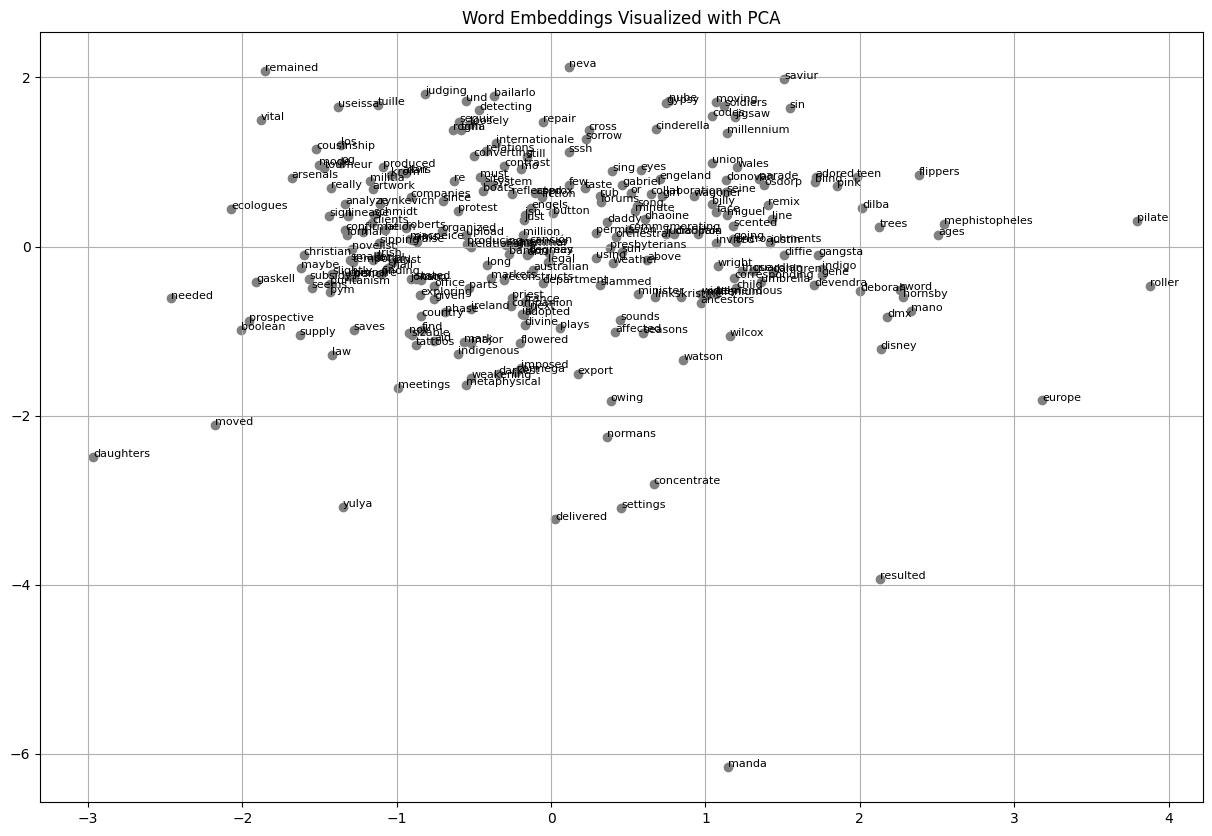

In [ ]:
# PCA
reduced = PCA(n_components=2).fit_transform(embedding_subset)
plot_words(reduced, words_subset, 'PCA')

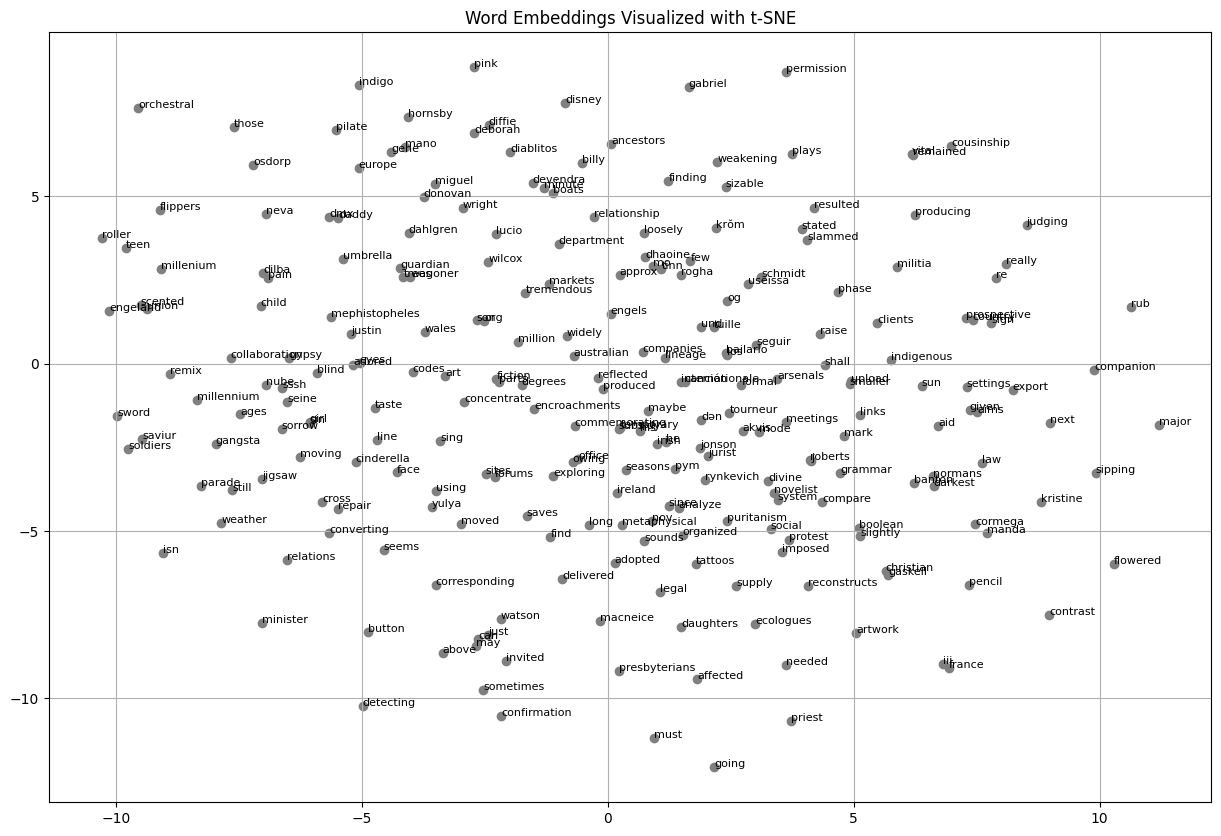

In [ ]:
# t-SNE
reduced = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(embedding_subset)
plot_words(reduced, words_subset, 't-SNE')

Note: words with similar contexts are closer in the 2D space.  
- PCA preserve global structure (variance) and is best for understanding variance directions.  
- t-SNE preserve local structure and best for visualising clusters of similar points.

# Question 2: Transformer model *(70 points)*

As a Machine Learning engineer at a tech company, you were given a task to develop a machine translation system that translates **English (source) to German (Target)**. You have the freedom to select any dataset for training the model. Use a small subset of data as a validation dataset and report the BLEU score on the validation set.

Also, provide a short description of your transformer model architecture, hyperparameters, and training (also provide the train-validation loss curve). Write your findings and analysis in paragraphs.


**Dataset**

Here are some of the parallel datasets (see Datasets and Resources file):
* Europarl Parallel corpus - https://www.statmt.org/europarl/v7/de-en.tgz
* News Commentary - https://www.statmt.org/wmt14/training-parallel-nc-v9.tgz (use DE-EN parallel data)
* Common Crawl corpus - https://www.statmt.org/wmt13/training-parallel-commoncrawl.tgz (use DE-EN parallel data)

You can also use other datasets of your choice. In this case please add the dataset you used to the submission zip file.

In the above datasets, **'.en'** file has the text in English, and **'.de'** file contains their corresponding German translations.



## Notes:
1. You can also consider using a small subset of the dataset if the training dataset is large
2. Sometimes you can also get out of memory errors while training, so choose the hyperparameters carefully.
3. Your training will be much faster if you use a GPU (Edit -> Notebook settings). If you are using a CPU, it may take several hours or even days. (you can also use Google Colab GPUs for training. link: https://colab.research.google.com/)
4. It is a best practise to leverage vector representations learned in Q1 in your training as starting point for the embedding layer.




**References**  
- Code adapted from: https://debuggercafe.com/language-translation-using-pytorch-transformer/.
- Dataset from: https://www.statmt.org/wmt14/training-parallel-nc-v9.tgz

1. Install dependencies

In [ ]:
# !pip install torch==2.0.1+cu117 torchvision==0.15.2+cu117 torchtext==0.15.2 --index-url https://download.pytorch.org/whl/cu117
# !pip install -U spacy
# !pip install sacrebleu

In [ ]:
# !pip install -U portalocker
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm

2. Imports & set seed

In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import sacrebleu

import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

import requests
import tarfile
import os
import re
import pandas as pd

In [ ]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

3. Data preprocessing

In [5]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'de'

# Place-holders
token_transform = {}
vocab_transform = {}

In [6]:
# Download and unzip file
url = "https://www.statmt.org/wmt14/training-parallel-nc-v9.tgz"
filename = "news-commentary.tgz"
extract_path = ""

response = requests.get(url)
with open(filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)
print("Download complete.")

with tarfile.open(filename, "r:gz") as tar:
    tar.extractall(path=extract_path)
print("Extraction complete.")

Download complete.
Extraction complete.


In [7]:
def clean_text(text):

    # # Convert text to lowercase
    # text = str(text).lower().strip()

    # Remove the \n at the end of each line in the file
    text = text.rstrip('\n')

    # # Remove HTML tags and non-alphanumeric characters
    # text = re.sub(r"<[^>]+>", "", text)
    # text = re.sub(r"[^a-zA-ZÀ-ÿ0-9\s.,;!?':()\[\]{}-]", " ", text)  # Keep selected punctuation marks, symbols and apostrophes

    # Remove excessive whitespace (more than one space)
    text = re.sub(r"\s+", " ", text)

    text = text.encode("utf-8", errors="ignore").decode("utf-8")  # Corrected encoding

    return text

In [8]:
en_filename = "training/news-commentary-v9.de-en.en"
de_filename = "training/news-commentary-v9.de-en.de"

# Cast the data from en & de files into a DataFrame
with open(en_filename, 'r') as en_file, open(de_filename, 'r') as de_file:
    en = pd.Series(en_file.readlines(), name=SRC_LANGUAGE).apply(lambda text: clean_text(text))
    de = pd.Series(de_file.readlines(), name=TGT_LANGUAGE).apply(lambda text: clean_text(text))
translation_df = pd.concat([en, de], axis=1).head(20000)
translation_df.head()

,en,de
0,"$10,000 Gold?",Steigt Gold auf 10.000 Dollar?
1,SAN FRANCISCO – It has never been easy to have...,"SAN FRANCISCO – Es war noch nie leicht, ein ra..."
2,"Lately, with gold prices up more than 300% ove...",In letzter Zeit allerdings ist dies schwierige...
3,"Just last December, fellow economists Martin F...",Erst letzten Dezember verfassten meine Kollege...
4,Wouldn’t you know it?,"Und es kam, wie es kommen musste."


In [9]:
# Get respective tokenizers
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')

In [10]:
# Train-test data split
train_csv, test_csv = train_test_split(translation_df, test_size=0.1)

print(len(train_csv))
print(len(test_csv))

18000
2000


In [11]:
# Custom Dataset class.
class TranslationDataset(Dataset):
    def __init__(self, csv):
        self.csv = csv

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        return(
            self.csv['en'].iloc[idx],
            self.csv['de'].iloc[idx]
        )

train_dataset = TranslationDataset(train_csv)
valid_dataset = TranslationDataset(test_csv)

# Check
iterator = iter(train_dataset)
print(next(iterator))

('Equally important are strategic concerns about transnational terrorism and the rise of Chinese power.', 'Genauso wichtig sind strategische Bedenken im Hinblick auf den grenzüberschreitenden Terrorismus und die zunehmende Macht Chinas.')


In [12]:
# Helper function to yield list of tokens.
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        text = data_sample[language_index[language]]

        # skip non-string samples or log a warning
        # if not isinstance(text, str):
        #     continue
        yield token_transform[language](str(text))

# Define special symbols and indices.
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
# UNK_IDX: Represents unknown words.
# PAD_IDX: Used for padding shorter sequences.
# BOS_IDX: Denotes the beginning of a sequence.
# EOS_IDX: Denotes the end of a sequence.

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Create torchtext's Vocab object.
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_dataset, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [13]:
# Helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# Function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# `src` and `tgt` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # Tokenization
                                               vocab_transform[ln], # Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# Function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []

    # Text transform each sample
    for src_sample, tgt_sample in batch:
        if not isinstance(src_sample, str) or not isinstance(tgt_sample, str):
            continue
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    # Pad source and target sequence
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

4. Transformer model

In [14]:
# Generates casual mask for decoder part of Transformer
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Creates mask
def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    # Casual mask for decoder self-attention to prevent it from seeing future tokens
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    # No masking for encoder
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    # Padding mask to prevent model from attending <pad> tokens
    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [15]:
class PositionalEncoding(nn.Module):
    # To add position-specific vectors to each word's embedding

    def __init__(self, d_model, dropout, max_len=5000):
        """
        :param max_len: Input length sequence.
        :param d_model: Embedding dimension.
        :param dropout: Dropout value (default=0.1)
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Inputs of forward function
        :param x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [16]:
class TokenEmbedding(nn.Module):
    # Map token IDs to dense embedding vectors and scale them

    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [17]:
class Seq2SeqTransformer(nn.Module):
    # Sequence to sequence architecture for Transformer
    # To use in machine translation, from English to German

    def __init__(
        self,
        num_encoder_layers: int,
        num_decoder_layers: int,
        emb_size: int,
        nhead: int,
        src_vocab_size: int,
        tgt_vocab_size: int,
        dim_feedforward: int = 512,
        dropout: float = 0.1
    ):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        # Linear layer to map transformer's output to vocab logits
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

        # Token embedding layers for source and target languages
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)

        # Add positional information to token embeddings
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):

        # Ensure masks are of the same type -- to prevent attending to future positions
        tgt_mask = tgt_mask.bool()  # if using bool-based masking
        src_mask = src_mask.bool()

        src_padding_mask = src_padding_mask.bool()
        tgt_padding_mask = tgt_padding_mask.bool()
        memory_key_padding_mask = memory_key_padding_mask.bool()

        # Convert token IDs into dense embeddings and add positional encodings
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        # Feeds input through the Transformer model
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)

        # Final linear layer projects the output
        return self.generator(outs)


    # Encodes source input into memory tensor
    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    # Decodes the target sequence using memory from the encoder
    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

5. Training and Evaluation

In [18]:
# Training hyperparameters
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])       # Source language vocabulary size
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])       # Target language vocabulary size
EMB_SIZE = 192                                            # Embedding Size
NHEAD = 6                                                 # Heads in Multi-Head Attention
FFN_HID_DIM = 192                                         # Feed-Forward Network Dimension
BATCH_SIZE = 16                                           # Batch Size
NUM_ENCODER_LAYERS = 3                                    # Number of Encoder Layers
NUM_DECODER_LAYERS = 3                                    # Number of Decoder Layers
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'   # Device for Computation
NUM_EPOCHS = 50

In [19]:
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    EMB_SIZE,
    NHEAD,
    SRC_VOCAB_SIZE,
    TGT_VOCAB_SIZE,
    FFN_HID_DIM
).to(DEVICE)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
print(model)

21,670,726 total parameters.
21,670,726 training parameters.
Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
          )
          (linear1): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=192, out_features=192, bias=True)
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x Tr

In [20]:
# Loss function and optimiser
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [21]:
# Helper: Decode Token IDs to Words
def decode_tokens(tokens, vocab, remove_special_tokens=True):
    words = vocab.lookup_tokens(list(tokens))
    if remove_special_tokens:
        words = [w for w in words if w not in ['<bos>', '<eos>', '<pad>']]
    return words

In [22]:
# Train function
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def train_epoch(model, optimizer):
    print('Training')
    model.train()
    losses = 0

    for src, tgt in tqdm(train_dataloader, total=len(list(train_dataloader))):
        # print(" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        # print(" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]

        # Creates attention and padding masks for src and tgt inputs
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        # Forward pass
        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask
        )

        # Clears gradients before backpropagation
        optimizer.zero_grad()

        # Computes the loss between model outputs and true target outputs.
        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1).long())
        loss.backward()

        # Computes gradients and updates model weights.
        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


# Validation function
val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def evaluate(model):
    print('Validating')
    model.eval()
    losses = 0
    total_bleu = 0
    count = 0
    smoothing = SmoothingFunction().method1

    for src, tgt in tqdm(val_dataloader, total=len(list(val_dataloader))):
        # print(" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        # print(" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]

        # Creates attention and padding masks for src and tgt inputs
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        # Forward pass
        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask
        )

        # Computes the loss between model outputs and true target outputs.
        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1).long())
        losses += loss.item()


        # Get predictions for BLEU
        predicted_tokens = logits.argmax(-1)  # shape: (batch_size, tgt_len)
        for pred, truth in zip(predicted_tokens, tgt_out):
            # Remove special tokens (e.g., <bos>, <eos>, <pad>)
            pred_tokens = vocab_transform[TGT_LANGUAGE].lookup_tokens(pred.detach().cpu().tolist())
            truth_tokens = vocab_transform[TGT_LANGUAGE].lookup_tokens(truth.detach().cpu().tolist())

            # Clean
            pred_tokens = [t for t in pred_tokens if t not in special_symbols]
            truth_tokens = [t for t in truth_tokens if t not in special_symbols]

            if len(pred_tokens) > 0 and len(truth_tokens) > 0:
                bleu = sentence_bleu([truth_tokens], pred_tokens, smoothing_function=smoothing)
                total_bleu += bleu
                count += 1

    avg_bleu = total_bleu / count if count > 0 else 0

    return losses / len(list(val_dataloader)), avg_bleu

In [23]:
train_loss_list, valid_loss_list, avg_bleu_list = [], [], []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    valid_loss, avg_bleu = evaluate(model)
    end_time = timer()
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    avg_bleu_list.append(avg_bleu)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, BLEU score: {avg_bleu:.4f}, "f"Epoch time = {(end_time - start_time):.3f}s \n"))

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 1, Train loss: 7.387, Val loss: 6.885, BLEU score: 0.0073, Epoch time = 81.567s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 2, Train loss: 6.728, Val loss: 6.718, BLEU score: 0.0082, Epoch time = 75.729s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 3, Train loss: 6.526, Val loss: 6.635, BLEU score: 0.0086, Epoch time = 75.113s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 4, Train loss: 6.379, Val loss: 6.568, BLEU score: 0.0088, Epoch time = 74.792s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 5, Train loss: 6.255, Val loss: 6.500, BLEU score: 0.0090, Epoch time = 75.006s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 6, Train loss: 6.147, Val loss: 6.439, BLEU score: 0.0093, Epoch time = 75.454s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 7, Train loss: 6.054, Val loss: 6.380, BLEU score: 0.0095, Epoch time = 75.734s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 8, Train loss: 5.968, Val loss: 6.343, BLEU score: 0.0098, Epoch time = 75.436s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 9, Train loss: 5.891, Val loss: 6.299, BLEU score: 0.0104, Epoch time = 75.422s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 10, Train loss: 5.820, Val loss: 6.276, BLEU score: 0.0106, Epoch time = 76.616s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 11, Train loss: 5.754, Val loss: 6.239, BLEU score: 0.0110, Epoch time = 74.941s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 12, Train loss: 5.693, Val loss: 6.210, BLEU score: 0.0111, Epoch time = 74.331s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 13, Train loss: 5.634, Val loss: 6.184, BLEU score: 0.0113, Epoch time = 74.235s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 14, Train loss: 5.577, Val loss: 6.158, BLEU score: 0.0116, Epoch time = 74.264s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 15, Train loss: 5.525, Val loss: 6.132, BLEU score: 0.0119, Epoch time = 74.474s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 16, Train loss: 5.476, Val loss: 6.117, BLEU score: 0.0123, Epoch time = 74.286s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 17, Train loss: 5.429, Val loss: 6.087, BLEU score: 0.0126, Epoch time = 74.380s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 18, Train loss: 5.384, Val loss: 6.067, BLEU score: 0.0127, Epoch time = 74.829s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 19, Train loss: 5.338, Val loss: 6.054, BLEU score: 0.0130, Epoch time = 75.095s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 20, Train loss: 5.299, Val loss: 6.041, BLEU score: 0.0129, Epoch time = 75.466s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 21, Train loss: 5.260, Val loss: 6.032, BLEU score: 0.0132, Epoch time = 77.310s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 22, Train loss: 5.221, Val loss: 6.016, BLEU score: 0.0132, Epoch time = 76.775s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 23, Train loss: 5.185, Val loss: 6.007, BLEU score: 0.0138, Epoch time = 78.065s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 24, Train loss: 5.148, Val loss: 5.989, BLEU score: 0.0138, Epoch time = 78.134s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 25, Train loss: 5.114, Val loss: 5.980, BLEU score: 0.0140, Epoch time = 77.087s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 26, Train loss: 5.081, Val loss: 5.964, BLEU score: 0.0140, Epoch time = 75.899s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 27, Train loss: 5.049, Val loss: 5.952, BLEU score: 0.0140, Epoch time = 74.697s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 28, Train loss: 5.019, Val loss: 5.940, BLEU score: 0.0137, Epoch time = 74.615s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 29, Train loss: 4.987, Val loss: 5.937, BLEU score: 0.0138, Epoch time = 74.688s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 30, Train loss: 4.957, Val loss: 5.923, BLEU score: 0.0141, Epoch time = 74.724s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 31, Train loss: 4.928, Val loss: 5.912, BLEU score: 0.0143, Epoch time = 74.817s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 32, Train loss: 4.900, Val loss: 5.893, BLEU score: 0.0144, Epoch time = 75.196s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 33, Train loss: 4.873, Val loss: 5.892, BLEU score: 0.0144, Epoch time = 75.305s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 34, Train loss: 4.847, Val loss: 5.887, BLEU score: 0.0145, Epoch time = 74.839s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 35, Train loss: 4.821, Val loss: 5.881, BLEU score: 0.0146, Epoch time = 74.969s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 36, Train loss: 4.797, Val loss: 5.867, BLEU score: 0.0148, Epoch time = 75.396s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 37, Train loss: 4.777, Val loss: 5.845, BLEU score: 0.0151, Epoch time = 76.200s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 38, Train loss: 4.753, Val loss: 5.820, BLEU score: 0.0151, Epoch time = 75.155s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 39, Train loss: 4.732, Val loss: 5.806, BLEU score: 0.0152, Epoch time = 76.513s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 40, Train loss: 4.709, Val loss: 5.814, BLEU score: 0.0154, Epoch time = 76.924s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 41, Train loss: 4.689, Val loss: 5.804, BLEU score: 0.0154, Epoch time = 76.296s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 42, Train loss: 4.669, Val loss: 5.805, BLEU score: 0.0154, Epoch time = 76.543s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 43, Train loss: 4.646, Val loss: 5.790, BLEU score: 0.0160, Epoch time = 77.259s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 44, Train loss: 4.629, Val loss: 5.781, BLEU score: 0.0164, Epoch time = 75.963s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 45, Train loss: 4.609, Val loss: 5.793, BLEU score: 0.0161, Epoch time = 74.843s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 46, Train loss: 4.593, Val loss: 5.777, BLEU score: 0.0162, Epoch time = 74.892s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 47, Train loss: 4.573, Val loss: 5.776, BLEU score: 0.0163, Epoch time = 74.966s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 48, Train loss: 4.559, Val loss: 5.767, BLEU score: 0.0164, Epoch time = 75.496s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 49, Train loss: 4.544, Val loss: 5.754, BLEU score: 0.0165, Epoch time = 75.368s 

Training


  0%|          | 0/1125 [00:00<?, ?it/s]

Validating


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 50, Train loss: 4.526, Val loss: 5.748, BLEU score: 0.0161, Epoch time = 75.515s 



In [24]:
def save_plots(train_loss, valid_loss, avg_bleu):
    """
    Function to save the loss plots to disk.
    """
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot train and validation loss on primary y-axis
    ax1.plot(train_loss, color='blue', linestyle='-', label='Train Loss')
    ax1.plot(valid_loss, color='red', linestyle='-', label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Second y-axis for BLEU scores
    ax2 = ax1.twinx()
    ax2.plot(avg_bleu_list, color='orange', linestyle='-', label='Average BLEU')
    ax2.set_ylabel('BLEU Score', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    # Save and show
    plt.title('Training Loss, Validation Loss & BLEU Score Over Epochs')
    plt.tight_layout()
    os.makedirs('outputs', exist_ok=True)
    plt.savefig(os.path.join('outputs', 'loss_bleu.png'))
    plt.show()


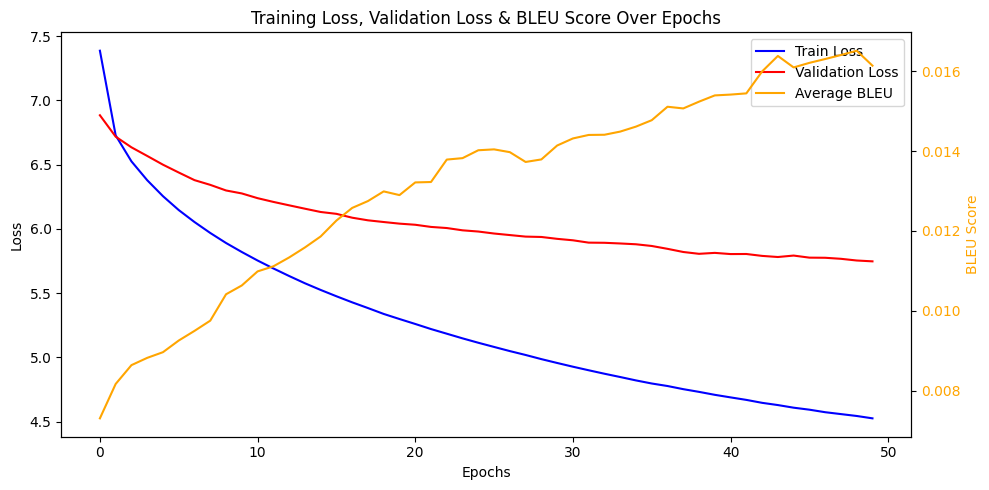

In [25]:
# Save model and output
os.makedirs('outputs', exist_ok=True)
save_plots(train_loss_list, valid_loss_list, avg_bleu_list)
torch.save(model, 'outputs/model.pth')

6. Testing and Inference

In [31]:
# Helper function to generate output sequence using greedy algorithm.
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        if i == 0:
            ys = ys.transpose(1, 0)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys

# Translation function.
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    tokens_int = [int(token) for token in tgt_tokens.cpu().tolist()]  # <-- Cast to int here
    return " ".join(
        vocab_transform[TGT_LANGUAGE].lookup_tokens(tokens_int)
    ).replace("<bos>", "").replace("<eos>", "")


In [40]:
# Perform translation and calculation of BLEU score
comparison_df = test_csv.copy(deep=True)
comparison_df['translated'] = comparison_df['en'].apply(lambda x: translate(model, x))
comparison_df['bleu'] = comparison_df.apply(
    lambda x: sacrebleu.corpus_bleu(
        [x['translated']],     # hypothesis: list of strings
        [[x['de']]],           # reference: list of list of strings
        tokenize='none'
    ).score,
    axis=1
)

comparison_df = comparison_df.sort_values(by='bleu', ascending=False)

In [41]:
# Good translation
for idx, row in comparison_df.head(10).iterrows():
    print(f"EN:\t\t {row['en']}")
    print(f"DE:\t\t {row['de']}")
    print(f"DE_pred:\t {row['translated']}")
    print(f"BLEU score:\t {row['bleu']:.3f}\n")

EN:		 A Fair Deal for Turkey
DE:		 Ein fairer Deal für die Türkei
DE_pred:	  Eine Türkei für die Türkei 
BLEU score:	 32.556

EN:		 Why was this?
DE:		 Warum war das so?
DE_pred:	  Warum war dies ? 
BLEU score:	 31.947

EN:		 A Fresh Start for Europe
DE:		 Neuanfang für Europa
DE_pred:	  Ein Europa für Europa 
BLEU score:	 31.947

EN:		 How well have the world’s governments performed this task over the past three years?
DE:		 Wie gut haben die Regierungen weltweit in den letzten drei Jahren diese Aufgabe erfüllt?
DE_pred:	  Wie haben die Welt in den letzten drei Jahren die Zukunft ? 
BLEU score:	 31.913

EN:		 In the United States, there were two key decisions.
DE:		 In den Vereinigten Staaten gab es zwei solcher Grundsatzentscheidungen.
DE_pred:	  In den Vereinigten Staaten wurden die Vereinigten Staaten . 
BLEU score:	 29.847

EN:		 We are students, not soldiers.
DE:		 Wir sind Studenten, keine Soldaten.
DE_pred:	  Wir sind nicht . 
BLEU score:	 24.880

EN:		 At the Cold War’s end, J

In [42]:
# Bad translation
for idx, row in comparison_df.tail().iterrows():
    print(f"EN:\t\t {row['en']}")
    print(f"DE:\t\t {row['de']}")
    print(f"DE_pred:\t {row['translated']}")
    print(f"BLEU score:\t {row['bleu']:.3f}\n")

EN:		 Pessimistic Doha: 25% liberalization
DE:		 Pessimistisches Doha-Ziel: 25 % Liberalisierung
DE_pred:	  Die Revolution der Revolution 
BLEU score:	 0.000

EN:		 Education
DE:		 Bildung
DE_pred:	  Bildung 
BLEU score:	 0.000

EN:		 This proposal is far superior to its predecessors.
DE:		 Dieser Vorschlag übertrifft alle bisher vorgelegten.
DE_pred:	  Dies ist nicht weit davon , um seine Sicherheit zu retten . 
BLEU score:	 0.000

EN:		 Of course, individual developing countries may be spared.
DE:		 Selbstverständlich können einzelne Entwicklungsländer davon ausgenommen bleiben.
DE_pred:	  Natürlich kann man auch nicht in der Lage sein . 
BLEU score:	 0.000

EN:		 Africa\u0027s Child Soldiers
DE:		 Afrikas Kinder-Soldaten
DE_pred:	  Die meisten Europäer 
BLEU score:	 0.000



### Additional Experiments *(5 additional points - <span style="color: red;">Optional</span>)*